<a href="https://colab.research.google.com/github/nazwan14/Data-Science/blob/main/Russia_vs_Ukraine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import re
from nltk.corpus import stopwords
import string

# Mengambil Data

In [54]:


# --- KONFIGURASI PENTING ---
# GANTI JALUR INI (PATH) DENGAN LOKASI FILE ANDA DI DRIVE
# Contoh umum: My Drive/Colab Notebooks/Russian vs Ukraine dataset.csv
FILE_PATH = '/content/drive/MyDrive/Russian vs Ukraine dataset.csv'
df = None
delimiters = [',', ';', '\t'] # Try comma, semicolon, then tab

for delimiter in delimiters:
    try:
        print(f"Trying to load data with delimiter: '{delimiter}'...")
        df = pd.read_csv(FILE_PATH, encoding='latin1', sep=delimiter)
        print(f"Data loaded successfully with delimiter '{delimiter}'.")
        break # Exit loop if successful
    except pd.errors.ParserError as e:
        print(f"ParserError with delimiter '{delimiter}': {e}")
        continue # Try next delimiter
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        break # Stop if it's not a ParserError

if df is not None:
    print("Data loaded successfully. Here's the head of the dataframe:")
    print(df.head())
else:
    print("Failed to load data with common delimiters. Please check the file's structure and encoding.")

Trying to load data with delimiter: ','...
Data loaded successfully with delimiter ','.
Data loaded successfully. Here's the head of the dataframe:
                    id      conversation_id               created_at  \
0  1630366235354451969  1630152070530576385  2023-02-28 00:36:15 UTC   
1  1630366226424778753  1630366226424778753  2023-02-28 00:36:13 UTC   
2  1630366225930027011  1630366225930027011  2023-02-28 00:36:13 UTC   
3  1630366223056662530  1630351686974992385  2023-02-28 00:36:12 UTC   
4  1630366221483884545  1629903982255644672  2023-02-28 00:36:12 UTC   

         date      time  timezone              user_id     username  \
0  2023-02-28  00:36:15         0  1493761817406894086  tomasliptai   
1  2023-02-28  00:36:13         0  1526694166662721536  paperfloure   
2  2023-02-28  00:36:13         0  1053018392939167746    katetbar1   
3  2023-02-28  00:36:12         0            602371247    jlhrdhmom   
4  2023-02-28  00:36:12         0  1053594763214184448    phemik

In [55]:
print(df.columns)

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')


# Text Preprocessing and Cleaning

Analisis hanya menggunakan 3 kolom ini

In [56]:
df = df[["username", "tweet", "language"]]


Cek null value

In [57]:
df.isnull().sum()

,0
username,0
tweet,0
language,0


cek bahasa apa saja yang ada di data

In [58]:
df["language"].value_counts()

,count
language,
en,8858
pt,440
it,194
qme,105
und,60
in,47
ru,44
ja,42
es,36


Cleaning

In [59]:
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
df["tweet"] = df["tweet"].apply(clean)

<>:6: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\w'
<>:6: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-3854852780.py:6: SyntaxWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', '', text)
/tmp/ipython-input-3854852780.py:7: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)
/tmp/ipython-input-3854852780.py:11: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d\w*', '', text)


Menggunakan workcloud untuk melihat kata apa yang paling sering digunakan

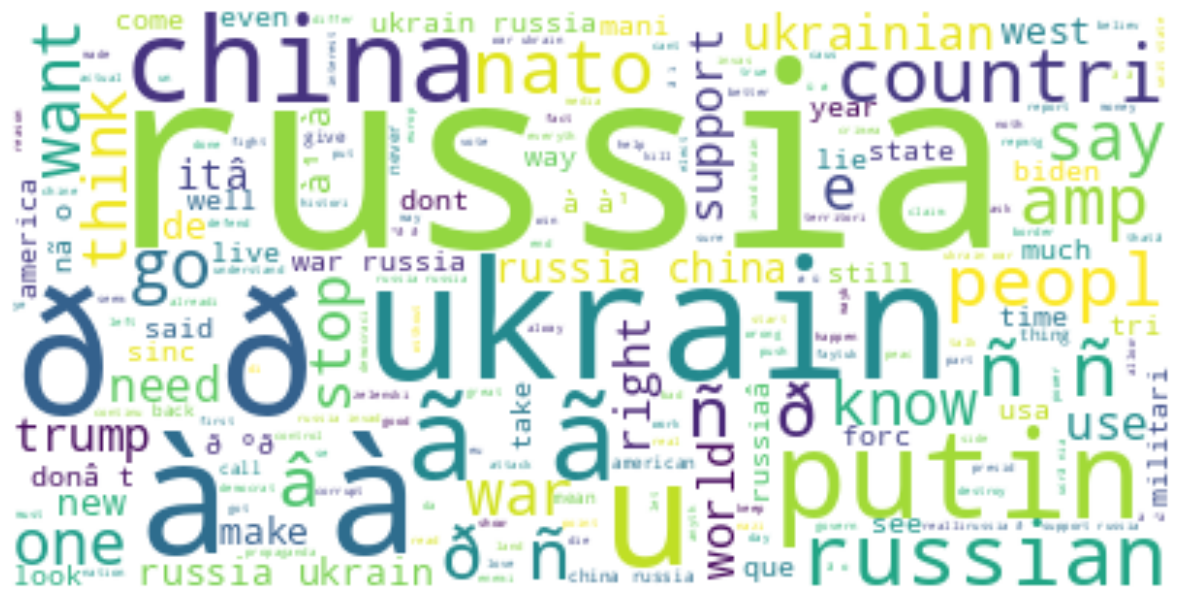

In [60]:


text = " ".join(i for i in df.tweet)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Analisis Sentimen Ganda

## Vader

In [64]:
nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()
df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["tweet"]]
df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["tweet"]]
df["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df["tweet"]]
df = df[["tweet", "Positive", "Negative", "Neutral"]]
print(df.head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                               tweet  Positive  Negative  \
0      nazijaeg derwen  russia place satan rule well     0.259     0.000   
1  russia haarp could destroy usa one fell swoop ...     0.000     0.280   
2       putin give steven seagal  order friendship       0.367     0.000   
3    mainelif baddcompani itâ alway project russia     0.000     0.000   
4  pottingpink mfarussia modrussia milhistrf muze...     0.065     0.076   

   Neutral  
0    0.741  
1    0.720  
2    0.633  
3    1.000  
4    0.859  


## Transformer model(Hugging Face)

In [65]:
# =================================================================
# 4B. ANALISIS SENTIMEN DENGAN TRANSFORMER (Model Lanjutan)
# =================================================================
import numpy as np
from transformers import pipeline

# Rename 'tweet' column to 'processed_text' for consistency with subsequent steps
# and create a consolidated VADER sentiment column
if 'tweet' in df.columns:
    df = df.rename(columns={'tweet': 'processed_text'})

# Create 'sentiment_vader' column from VADER scores (Positive, Negative, Neutral)
def get_vader_sentiment_label(row):
    pos = row['Positive']
    neg = row['Negative']
    neu = row['Neutral']
    if pos > neg and pos > neu:
        return 'Positif'
    elif neg > pos and neg > neu:
        return 'Negatif'
    else:
        return 'Netral'
df['sentiment_vader'] = df.apply(get_vader_sentiment_label, axis=1)

# Define the text column name for the transformer
TEXT_COLUMN_NAME = 'processed_text'

# Menggunakan model standar yang cepat dan akurat untuk sentimen berbahasa Inggris
# 'distilbert-base-uncased-finetuned-sst-2-english'
try:
    sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=0) # device=0 untuk GPU jika tersedia

    # Kita hanya mengambil sampel kecil (misalnya 5000 data teratas) karena Transformer lambat pada CPU
    # Untuk dataset penuh, pertimbangkan menjalankan pada GPU
    N_SAMPLES = 5000
    sample_df = df.head(N_SAMPLES).copy()

    print(f"\nMenganalisis sentimen untuk {N_SAMPLES} sampel dengan Model Transformer...")

    # Jalankan pipeline pada kolom teks yang sudah diproses
    transformer_results = sentiment_pipeline(sample_df[TEXT_COLUMN_NAME].tolist())

    sample_df['sentiment_transformer'] = [res['label'] for res in transformer_results]
    sample_df['score_transformer'] = [res['score'] for res in transformer_results]

    # Menyesuaikan label ke format yang sama: POSITIVE/NEGATIVE
    sample_df['sentiment_transformer'] = sample_df['sentiment_transformer'].replace({'POSITIVE': 'Positif', 'NEGATIVE': 'Negatif'})

    # Gabungkan kembali hasil ke DataFrame utama
    df = df.merge(sample_df[['sentiment_transformer', 'score_transformer']],
                  left_index=True,
                  right_index=True,
                  how='left')

    # Isi nilai yang kosong (di luar N_SAMPLES) dengan 'Tidak Dihitung'
    df['sentiment_transformer'].fillna('Tidak Dihitung', inplace=True)
    df['score_transformer'].fillna(np.nan, inplace=True)

    print("\nContoh Hasil Transformer (5 Baris):")
    print(df[['processed_text', 'sentiment_vader', 'sentiment_transformer']].head())

except Exception as e:
    print(f"\n[INFO] Gagal menjalankan pipeline Transformer (mungkin karena resource CPU/GPU). Melewati langkah ini. Error: {e}")
    # Jika gagal, tetap lanjutkan dengan VADER saja
    df['sentiment_transformer'] = 'Tidak Dihitung (Error)'
    df['score_transformer'] = np.nan

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu



Menganalisis sentimen untuk 5000 sampel dengan Model Transformer...

Contoh Hasil Transformer (5 Baris):
                                      processed_text sentiment_vader  \
0      nazijaeg derwen  russia place satan rule well          Netral   
1  russia haarp could destroy usa one fell swoop ...          Netral   
2       putin give steven seagal  order friendship            Netral   
3    mainelif baddcompani itâ alway project russia          Netral   
4  pottingpink mfarussia modrussia milhistrf muze...          Netral   

  sentiment_transformer  
0               Positif  
1               Negatif  
2               Positif  
3               Negatif  
4               Negatif  


/tmp/ipython-input-2409615086.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sentiment_transformer'].fillna('Tidak Dihitung', inplace=True)
/tmp/ipython-input-2409615086.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

# Visualisasi

/tmp/ipython-input-488961724.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vader_counts.index, y=vader_counts.values, palette=sentiment_colors)


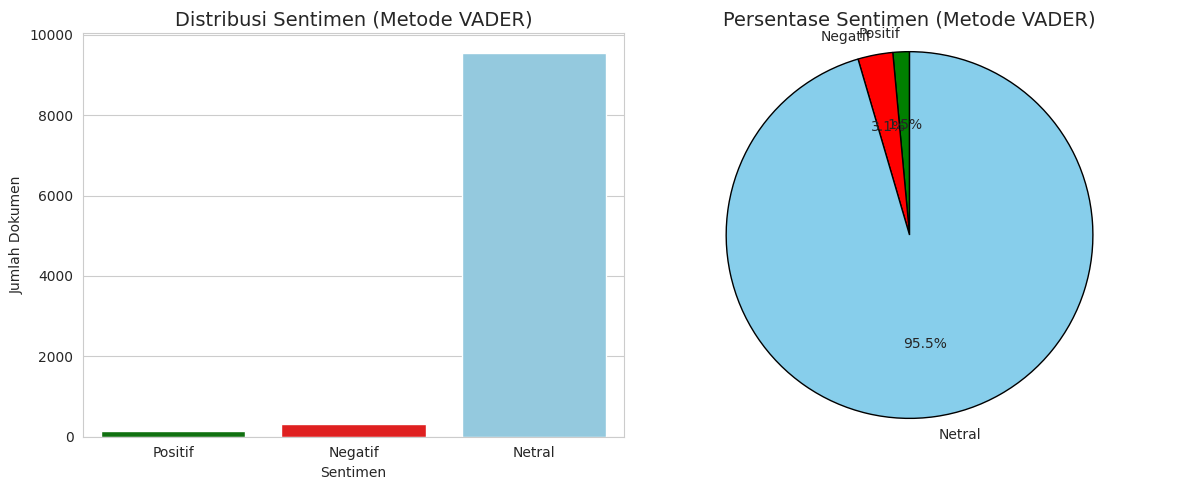

/tmp/ipython-input-488961724.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=transformer_counts.index, y=transformer_counts.values,


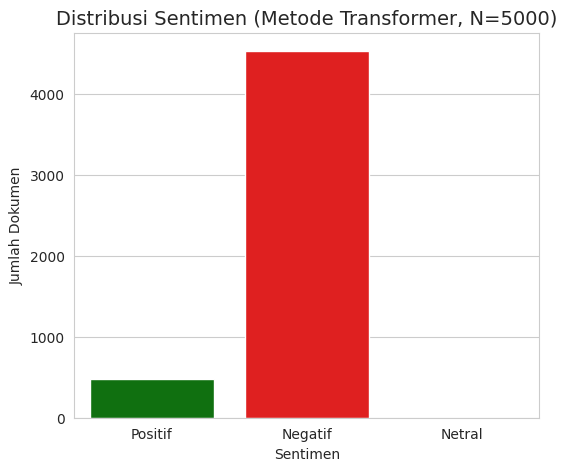


Menghasilkan perbandingan sentimen antara VADER dan Transformer...


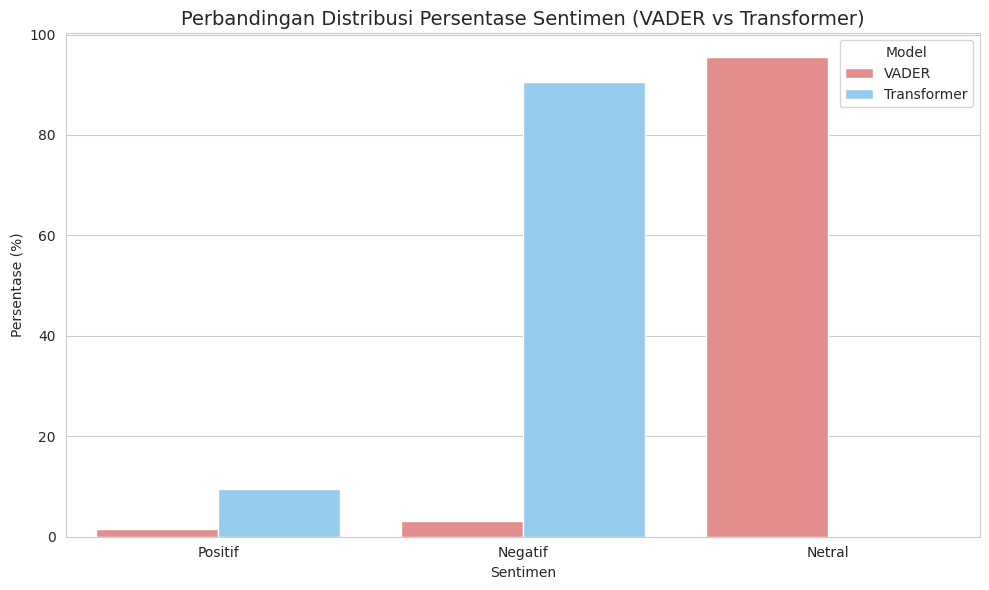

In [67]:
# =================================================================
# 5. VISUALISASI DAN PELAPORAN AKHIR
# =================================================================

# Define a consistent color mapping for sentiment categories
sentiment_colors = {'Positif': 'green', 'Negatif': 'red', 'Netral': 'skyblue'}

# --- 5.1. Plot Distribusi Sentimen VADER ---
if 'sentiment_vader' in df.columns and not df['sentiment_vader'].empty:
    vader_counts = df['sentiment_vader'].value_counts()
    # Reindex to ensure consistent order of categories (and thus colors) if some are missing
    vader_counts = vader_counts.reindex(index=['Positif', 'Negatif', 'Netral'], fill_value=0)

    plt.figure(figsize=(12, 5))

    # Plot Bar
    plt.subplot(1, 2, 1)
    sns.barplot(x=vader_counts.index, y=vader_counts.values, hue=vader_counts.index, palette=sentiment_colors, legend=False)
    plt.title('Distribusi Sentimen (Metode VADER)', fontsize=14)
    plt.ylabel('Jumlah Dokumen')
    plt.xlabel('Sentimen')

    # Plot Pie
    plt.subplot(1, 2, 2)
    # Ensure pie chart colors match the order of vader_counts.index after reindex
    pie_colors = [sentiment_colors[s] for s in vader_counts.index if s in sentiment_colors]
    plt.pie(vader_counts.values, labels=vader_counts.index, autopct='%1.1f%%', startangle=90,
            colors=pie_colors, wedgeprops={'edgecolor': 'black'})
    plt.title('Persentase Sentimen (Metode VADER)', fontsize=14)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("Kolom 'sentiment_vader' tidak ditemukan atau kosong untuk visualisasi VADER.")

# --- 5.2. Distribusi Sentimen Transformer ---
if 'sentiment_transformer' in df.columns and df['sentiment_transformer'].nunique() > 1:
    transformer_filtered_df = df[df['sentiment_transformer'] != 'Tidak Dihitung']
    if len(transformer_filtered_df) > 0:
        transformer_counts = transformer_filtered_df['sentiment_transformer'].value_counts()
        # Reindex to ensure consistent order of categories (and thus colors) if some are missing
        transformer_counts = transformer_counts.reindex(index=['Positif', 'Negatif', 'Netral'], fill_value=0)

        plt.figure(figsize=(6, 5))
        sns.barplot(x=transformer_counts.index, y=transformer_counts.values, hue=transformer_counts.index, palette=sentiment_colors, legend=False)
        plt.title(f'Distribusi Sentimen (Metode Transformer, N={len(transformer_filtered_df)})', fontsize=14)
        plt.ylabel('Jumlah Dokumen')
        plt.xlabel('Sentimen')
        plt.show()
    else:
        print("Data Transformer tidak cukup untuk visualisasi distribusi.")
else:
    print("Kolom 'sentiment_transformer' tidak tersedia atau tidak memiliki data yang cukup untuk visualisasi.")

# --- 5.3. Perbandingan Distribusi Sentimen Antara VADER dan Transformer ---
print("\nMenghasilkan perbandingan sentimen antara VADER dan Transformer...")

# Calculate normalized counts for VADER
vader_norm_counts = pd.DataFrame(columns=['Sentiment', 'Percentage', 'Model'])
if 'sentiment_vader' in df.columns and not df['sentiment_vader'].empty:
    vader_norm_counts = df['sentiment_vader'].value_counts(normalize=True).mul(100).rename('VADER').reset_index()
    vader_norm_counts.columns = ['Sentiment', 'Percentage']
    vader_norm_counts['Model'] = 'VADER'
    # Ensure consistent order for comparison plot
    vader_norm_counts['Sentiment'] = pd.Categorical(vader_norm_counts['Sentiment'], categories=['Positif', 'Negatif', 'Netral'])
    vader_norm_counts = vader_norm_counts.sort_values('Sentiment')

# Calculate normalized counts for Transformer
transformer_norm_counts = pd.DataFrame(columns=['Sentiment', 'Percentage', 'Model'])
if 'sentiment_transformer' in df.columns and df['sentiment_transformer'].nunique() > 1:
    transformer_filtered_df_for_comparison = df[df['sentiment_transformer'] != 'Tidak Dihitung']
    if len(transformer_filtered_df_for_comparison) > 0:
        transformer_norm_counts = transformer_filtered_df_for_comparison['sentiment_transformer'].value_counts(normalize=True).mul(100).rename('Transformer').reset_index()
        transformer_norm_counts.columns = ['Sentiment', 'Percentage']
        transformer_norm_counts['Model'] = 'Transformer'
        # Ensure consistent order for comparison plot
        transformer_norm_counts['Sentiment'] = pd.Categorical(transformer_norm_counts['Sentiment'], categories=['Positif', 'Negatif', 'Netral'])
        transformer_norm_counts = transformer_norm_counts.sort_values('Sentiment')

# Combine the dataframes if both have data
if not vader_norm_counts.empty and not transformer_norm_counts.empty:
    comparison_df = pd.concat([vader_norm_counts, transformer_norm_counts])

    plt.figure(figsize=(10, 6))
    sns.barplot(data=comparison_df, x='Sentiment', y='Percentage', hue='Model',
                palette={'VADER': 'lightcoral', 'Transformer': 'lightskyblue'}) # Specific colors for models
    plt.title('Perbandingan Distribusi Persentase Sentimen (VADER vs Transformer)', fontsize=14)
    plt.ylabel('Persentase (%)')
    plt.xlabel('Sentimen')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()
elif not vader_norm_counts.empty:
    print("Tidak ada data Transformer yang cukup untuk perbandingan, hanya menampilkan VADER.")
    plt.figure(figsize=(6, 5))
    sns.barplot(x=vader_norm_counts['Sentiment'], y=vader_norm_counts['Percentage'], hue=vader_norm_counts['Sentiment'],
                palette=sentiment_colors, legend=False) # Using sentiment_colors for consistency
    plt.title('Distribusi Persentase Sentimen (Metode VADER)', fontsize=14)
    plt.ylabel('Persentase (%)')
    plt.xlabel('Sentimen')
    plt.show()
elif not transformer_norm_counts.empty:
    print("Tidak ada data VADER yang cukup untuk perbandingan, hanya menampilkan Transformer.")
    plt.figure(figsize=(6, 5))
    sns.barplot(x=transformer_norm_counts['Sentiment'], y=transformer_norm_counts['Percentage'], hue=transformer_norm_counts['Sentiment'],
                palette=sentiment_colors, legend=False) # Using sentiment_colors for consistency
    plt.title('Distribusi Persentase Sentimen (Metode Transformer)', fontsize=14)
    plt.ylabel('Persentase (%)')
    plt.xlabel('Sentimen')
    plt.show()
else:
    print("Tidak ada data yang cukup dari kedua model untuk visualisasi perbandingan.")

Berdasarkan visualisasi perbandingan sentimen antara model VADER dan Transformer, berikut adalah kesimpulan yang dapat diambil:

Perbedaan Signifikan dalam Sentimen Netral: Perbedaan paling mencolok adalah dalam klasifikasi sentimen netral. Model VADER mengklasifikasikan mayoritas besar dari teks (sekitar 95.47%) sebagai 'Netral'. Sebaliknya, model Transformer tidak mengidentifikasi adanya sentimen 'Netral' sama sekali dalam sampel yang dianalisis. Ini menunjukkan bahwa kedua model memiliki cara yang sangat berbeda dalam menafsirkan teks yang tidak memiliki polaritas emosional yang kuat.

Dominasi Sentimen Negatif oleh Transformer: Untuk teks yang tidak dianggap netral, model Transformer menunjukkan dominasi sentimen 'Negatif' yang sangat tinggi (sekitar 90.52%) dibandingkan dengan sentimen 'Positif' (sekitar 9.48%).

Sentimen Positif Lebih Banyak Teridentifikasi oleh Transformer: Model Transformer mengidentifikasi proporsi sentimen 'Positif' yang lebih tinggi (9.48%) dibandingkan dengan model VADER (1.46%).

Ketidaksepakatan Antar Model: Secara keseluruhan, terdapat ketidaksepakatan yang signifikan antara kedua model mengenai distribusi sentimen. VADER cenderung lebih konservatif, mengklasifikasikan sebagian besar teks sebagai netral, sedangkan Transformer cenderung memberikan label positif atau negatif, dengan bias yang kuat ke arah negatif dalam kasus ini.

Kesimpulannya, model VADER dan Transformer memberikan perspektif yang sangat berbeda tentang sentimen data Anda. VADER cenderung menganggap sebagian besar teks tidak berafiliasi emosional, sedangkan Transformer lebih agresif dalam melabeli teks sebagai negatif atau positif.

# Import Hasil

In [68]:
# --- 6. Ekspor Hasil ---

# Export VADER results
output_file_vader = 'Analisis_Sentimen_VADER_HASIL.csv'
df_vader_export = df[['processed_text', 'Positive', 'Negative', 'Neutral', 'sentiment_vader']].copy()
df_vader_export.to_csv(output_file_vader, index=False)
print(f"\nHasil sentimen VADER disimpan di '{output_file_vader}'")

# Export Transformer results
output_file_transformer = 'Analisis_Sentimen_Transformer_HASIL.csv'
# Filter out 'Tidak Dihitung' if desired, or include them as is.
# For a cleaner export of actual Transformer results, we'll filter.
df_transformer_export = df[df['sentiment_transformer'] != 'Tidak Dihitung']
df_transformer_export = df_transformer_export[['processed_text', 'sentiment_transformer', 'score_transformer']].copy()
df_transformer_export.to_csv(output_file_transformer, index=False)
print(f"Hasil sentimen Transformer disimpan di '{output_file_transformer}'")

print(f"\n=========================================================")
print(f"ANALISIS SENTIMEN SELESAI!")
print(f"=========================================================")


Hasil sentimen VADER disimpan di 'Analisis_Sentimen_VADER_HASIL.csv'
Hasil sentimen Transformer disimpan di 'Analisis_Sentimen_Transformer_HASIL.csv'

ANALISIS SENTIMEN SELESAI!
